In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
from glob import glob

import sklearn
import numpy as np
import pandas as pd
from glob import glob

from keras.models import load_model

import matplotlib
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
file_path = Path(os.getcwd())
file_path

PosixPath('/vol/ml/apartin/projects/pilot1/apps/m14')

In [3]:
utils_path = file_path / '../../utils'
sys.path.append(str(utils_path))
import ml_models

In [4]:
%matplotlib inline

In [5]:
# Results dir
maindir = file_path / '../../out/m14/'
outdir = maindir/'plots'
os.makedirs(outdir, exist_ok=True)

In [6]:
runs = glob(str(maindir/'top21*'))
runs

['/vol/ml/apartin/projects/pilot1/apps/m14/../../out/m14/top21.nn_reg0.sgd.exp.cvf1.GE.DD.AUC_2019-8-15_h17-m52',
 '/vol/ml/apartin/projects/pilot1/apps/m14/../../out/m14/top21.nn_reg0.sgd.exp.cvf1.GE.DD.AUC_2019-8-15_h17-m54',
 '/vol/ml/apartin/projects/pilot1/apps/m14/../../out/m14/top21.nn_reg0.sgd.trng1.cvf1.GE.DD.AUC_2019-8-15_h17-m37',
 '/vol/ml/apartin/projects/pilot1/apps/m14/../../out/m14/top21.nn_reg0.sgd.cvf1.GE.DD.AUC_2019-8-15_h17-m37']

In [7]:
exp1_path  = Path(runs[0])
exp2_path  = Path(runs[1])
trgn1_path = Path(runs[2])
sgd_path   = Path(runs[3])

In [8]:
h_sgd = ml_models.plot_metrics_from_logs(
    Path(exp1_path)/'training.log', name='exp1', title=runs[0].split('/')[-1], outdir=outdir, skp_ep=2)

In [9]:
h_sgd = ml_models.plot_metrics_from_logs(
    Path(exp2_path)/'training.log', name='exp2', title=runs[0].split('/')[-1], outdir=outdir, skp_ep=2)

In [10]:
h_trng1 = ml_models.plot_metrics_from_logs(
    Path(trgn1_path)/'training.log', name='trng1', title=runs[0].split('/')[-1], outdir=outdir, skp_ep=2)

In [11]:
h_sgd = ml_models.plot_metrics_from_logs(
    Path(sgd_path)/'training.log', name='sgd', title=runs[0].split('/')[-1], outdir=outdir, skp_ep=2)

# Find convergence epoch

Convergence epoch (CE) is the epoch number at which the model reaches its best performance. For the same set of hyperparameters, CE may change across runs. We find CE across multiple runs (N=100) and the mean is our FOM.

In [39]:
ref_path = sgd_path
ref_path
ref_name = 'SGD'

In [40]:
# Define the metric based on which we compute the FOM
ref_metric = 'val_loss'
# fom_metric = 'val_mean_absolute_error'

In [41]:
# Load keras history
hname = 'krs_history.csv'
h_ref = pd.read_csv(ref_path/hname)

In [47]:
# Find the best score from history
convergence_value = h_ref[ref_metric].min()
convergence_epoch = h_ref.loc[ h_ref[ref_metric]==convergence_value, 'epoch' ].values[0]
print('ref_metric:', ref_metric)
print('convergence value: ', convergence_value)
print('convergence epoch: ', convergence_epoch)

ref_metric: val_loss
convergence value:  0.006721193117859066
convergence epoch:  371


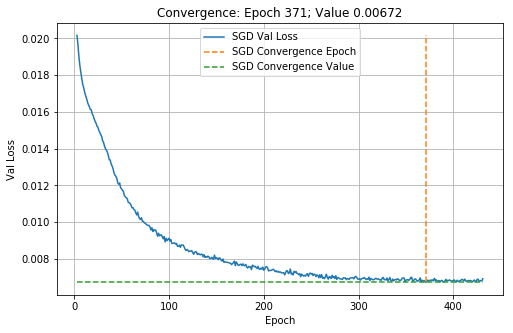

In [51]:
skp_ep = 2
ylabel = ' '.join(s.capitalize() for s in ref_metric.split('_'))

_, ax = plt.subplots(figsize=(8,5))
ax.plot(h_ref['epoch'][skp_ep:], h_ref[ref_metric][skp_ep:], label=f'{ref_name} {ylabel}')

# Mark ref_epoch
ax.plot(np.ones((20,))*ref_epoch,
        np.linspace(min(h_ref[ref_metric][skp_ep:]), max(h_ref[ref_metric][skp_ep:]), 20),
        '--', label=f'{ref_name} Convergence Epoch')

# Mark ref_value
xaxis = h_ref['epoch'][skp_ep:]
ax.plot(xaxis, np.ones((len(xaxis),))*ref_value, '--', label=f'{ref_name} Convergence Value')

ax.set_title(f'Convergence: Epoch {convergence_epoch}; Value {convergence_value:.5f}')
ax.set_xlabel('Epoch')
ax.set_ylabel(ylabel)
plt.legend(loc='best')
plt.grid(True)

# Find at what epoch CLR achieves the FOM of the baseline model

In [52]:
clr_path = trgn1_path
clr_path
clr_name = 'CLR'

In [53]:
# Load keras history
hname = 'krs_history.csv'
h_clr = pd.read_csv(clr_path/hname)

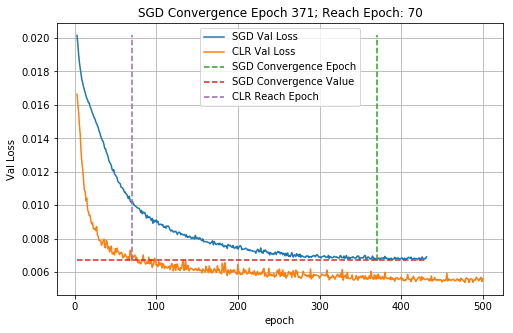

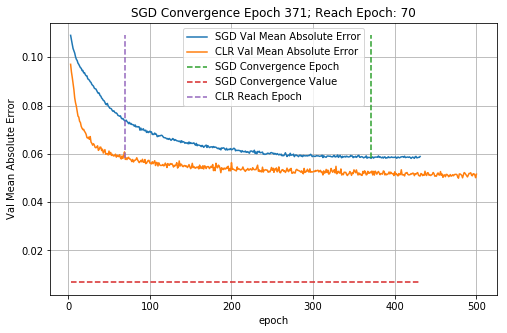

In [59]:
# Plot SGD vs CLR curves
skp_ep = 2

val_cols_names = [c for c in h_ref.columns if 'val_' in c]
for c in val_cols_names:
    ylabel = ' '.join(s.capitalize() for s in c.split('_'))
    
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(h_ref['epoch'][skp_ep:], h_ref[c][skp_ep:], label=f'{ref_name} {ylabel}')
    ax.plot(h_clr['epoch'][skp_ep:], h_clr[c][skp_ep:], label=f'{clr_name} {ylabel}')
    
    # Mark ref_epoch
    ax.plot(np.ones((2,))*ref_epoch,
        np.linspace(min(h_ref[c][skp_ep:]), max(h_ref[c][skp_ep:]), 2),
        '--', label=f'{ref_name} Convergence Epoch')
    
    # Mark ref_value
    xaxis = h_ref['epoch'][skp_ep:]
    ax.plot(xaxis, np.ones((len(xaxis),))*ref_value, '--', label=f'{ref_name} Convergence Value')
    
    # Mark reach_epoch
    # Find the index where the clr_value goes below ref_value
    idx_value = np.min(np.argwhere(h_clr[ref_metric].values < ref_value))
    # h_clr[ref_metric][idx_value]
    # print(ref_value)
    # print(h_clr[ref_metric][idx_value])
    reach_epoch = h_ref['epoch'][idx_value]
    ax.plot(np.ones((2,))*reach_epoch,
            np.linspace(min(h_ref[c][skp_ep:]), max(h_ref[c][skp_ep:]), 2),
            '--', label=f'{clr_name} Reach Epoch')
    
    ax.set_title(f'{ref_name} Convergence Epoch {convergence_epoch}; Reach Epoch: {reach_epoch}')
    ax.set_xlabel('epoch')
    ax.set_ylabel(ylabel)
    plt.legend(loc='best')
    plt.grid(True)
    # plt.savefig(outdir/f'ref_vs_wrm_{c}.png', bbox_inches='tight')

In [33]:
# Find the index where the clr_value goes below ref_value
idx_value = np.min(np.argwhere(h_clr[ref_metric].values < ref_value))
print(ref_value)
print(h_clr[ref_metric][idx_value])

0.006721193117859066
0.006685632665689547
